<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [5]:
%pip install tensorflow numpy pandas matplotlib seaborn scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import random
import io
import pickle
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.special import softmax

print("TensorFlow version:", tf.__version__)
print("Librerías importadas exitosamente")

TensorFlow version: 2.19.0
Librerías importadas exitosamente


In [7]:
print("=" * 80)
print("CONFIGURACIÓN INICIAL")
print("=" * 80)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Semillas configuradas con valor: {SEED}")

CONFIGURACIÓN INICIAL
Semillas configuradas con valor: 42


In [11]:
print("\n" + "=" * 80)
print("1. DESCARGA Y PREPARACIÓN DEL CORPUS")
print("=" * 80)

def download_songs_dataset():
    if not os.path.exists('./songs_dataset'):
        if not os.path.exists('songs_dataset.zip'):
            if platform.system() == 'Windows':
                !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
            else:
                !wget -O songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
        !unzip -q songs_dataset.zip
        print("Dataset de canciones descargado exitosamente")
    else:
        print("El dataset de canciones ya existe")

download_songs_dataset()



1. DESCARGA Y PREPARACIÓN DEL CORPUS
El dataset de canciones ya existe


In [12]:
available_files = os.listdir("./songs_dataset/")
print(f"\nArchivos disponibles: {len(available_files)} bandas/artistas")
for i, file in enumerate(available_files[:15]):
    print(f"  {i+1:2d}. {file}")
if len(available_files) > 15:
    print(f"      ... y {len(available_files) - 15} archivos más")



Archivos disponibles: 49 bandas/artistas
   1. prince.txt
   2. dickinson.txt
   3. notorious-big.txt
   4. beatles.txt
   5. bob-dylan.txt
   6. bjork.txt
   7. johnny-cash.txt
   8. disney.txt
   9. janisjoplin.txt
  10. kanye.txt
  11. bob-marley.txt
  12. leonard-cohen.txt
  13. ludacris.txt
  14. adele.txt
  15. alicia-keys.txt
      ... y 34 archivos más


In [13]:
print("\n" + "=" * 80)
print("2. SELECCIÓN Y CARGA DEL CORPUS")
print("=" * 80)

selected_artists = ['beatles.txt', 'bob-dylan.txt', 'nirvana.txt', 'radiohead.txt']

print(f"🎵 Artistas seleccionados para el corpus:")
for i, artist in enumerate(selected_artists, 1):
    artist_name = artist.replace('.txt', '').replace('-', ' ').title()
    print(f"  {i}. {artist_name}")

print(f"\n📝 Combinando múltiples artistas para crear un corpus rico y diverso")

def clean_song_lyrics(text):
    import re

    text = text.lower()

    lines = text.split('\n')
    cleaned_lines = []

    for line in lines:
        line = line.strip()
        words = line.split()

        if (len(words) >= 3 and
            not line.startswith('[') and
            not line.startswith('(') and
            not line.isupper() and
            len(line) > 10):
            cleaned_lines.append(line)

    return cleaned_lines

all_lyrics = []
artist_stats = {}

for artist_file in selected_artists:
    if artist_file in available_files:
        artist_name = artist_file.replace('.txt', '')

        try:
            with open(f'songs_dataset/{artist_file}', 'r', encoding='utf-8') as f:
                raw_text = f.read()
        except UnicodeDecodeError:
            with open(f'songs_dataset/{artist_file}', 'r', encoding='latin-1') as f:
                raw_text = f.read()

        cleaned_lyrics = clean_song_lyrics(raw_text)
        all_lyrics.extend(cleaned_lyrics)

        artist_stats[artist_name] = {
            'lines': len(cleaned_lyrics),
            'words': sum(len(line.split()) for line in cleaned_lyrics)
        }

        print(f"  ✓ {artist_name}: {len(cleaned_lyrics)} líneas procesadas")

df = pd.DataFrame(all_lyrics, columns=['text'])

print(f"\n📊 Estadísticas del corpus combinado:")
print(f"   • Total de líneas: {len(df):,}")
print(f"   • Total de palabras: {sum(len(line.split()) for line in all_lyrics):,}")

print(f"\n📈 Distribución por artista:")
for artist, stats in artist_stats.items():
    percentage = (stats['lines'] / len(df)) * 100
    print(f"   • {artist}: {stats['lines']:,} líneas ({percentage:.1f}%)")

print(f"\n🎶 Ejemplo de líneas del corpus:")
for i in range(min(8, len(df))):
    preview = df.iloc[i]['text']
    if len(preview) > 80:
        preview = preview[:80] + "..."
    print(f"  {i+1}. {preview}")

def compare_corpus_options():

    print(f"\n🔍 JUSTIFICACIÓN DEL CORPUS COMBINADO:")
    print(f"   ✅ Mayor diversidad estilística")
    print(f"   ✅ Vocabulario más rico y variado")
    print(f"   ✅ Diferentes épocas y géneros musicales")
    print(f"   ✅ Mejor generalización del modelo")
    print(f"   ✅ Corpus más robusto para entrenamiento")

    all_words = []
    for line in all_lyrics:
        all_words.extend(line.split())

    unique_words = len(set(all_words))
    total_words = len(all_words)
    diversity_ratio = unique_words / total_words

    print(f"\n📊 Métricas de diversidad:")
    print(f"   • Palabras únicas: {unique_words:,}")
    print(f"   • Palabras totales: {total_words:,}")
    print(f"   • Ratio de diversidad: {diversity_ratio:.3f}")

compare_corpus_options()


2. SELECCIÓN Y CARGA DEL CORPUS
🎵 Artistas seleccionados para el corpus:
  1. Beatles
  2. Bob Dylan
  3. Nirvana
  4. Radiohead

📝 Combinando múltiples artistas para crear un corpus rico y diverso
  ✓ beatles: 1795 líneas procesadas
  ✓ bob-dylan: 5131 líneas procesadas
  ✓ nirvana: 1713 líneas procesadas
  ✓ radiohead: 2071 líneas procesadas

📊 Estadísticas del corpus combinado:
   • Total de líneas: 10,710
   • Total de palabras: 75,185

📈 Distribución por artista:
   • beatles: 1,795 líneas (16.8%)
   • bob-dylan: 5,131 líneas (47.9%)
   • nirvana: 1,713 líneas (16.0%)
   • radiohead: 2,071 líneas (19.3%)

🎶 Ejemplo de líneas del corpus:
  1. yesterday, all my troubles seemed so far away
  2. now it looks as though they're here to stay
  3. oh, i believe in yesterday suddenly, i'm not half the man i used to be
  4. there's a shadow hanging over me.
  5. oh, yesterday came suddenly why she had to go i don't know she wouldn't say
  6. i said something wrong, now i long for yesterday


3. ANÁLISIS EXPLORATORIO Y ELECCIÓN DEL CONTEXTO
Estadísticas de longitud de secuencias:
  - Total de secuencias: 10710
  - Longitud promedio: 7.05
  - Longitud mínima: 1
  - Longitud máxima: 34
  - Mediana: 6.00


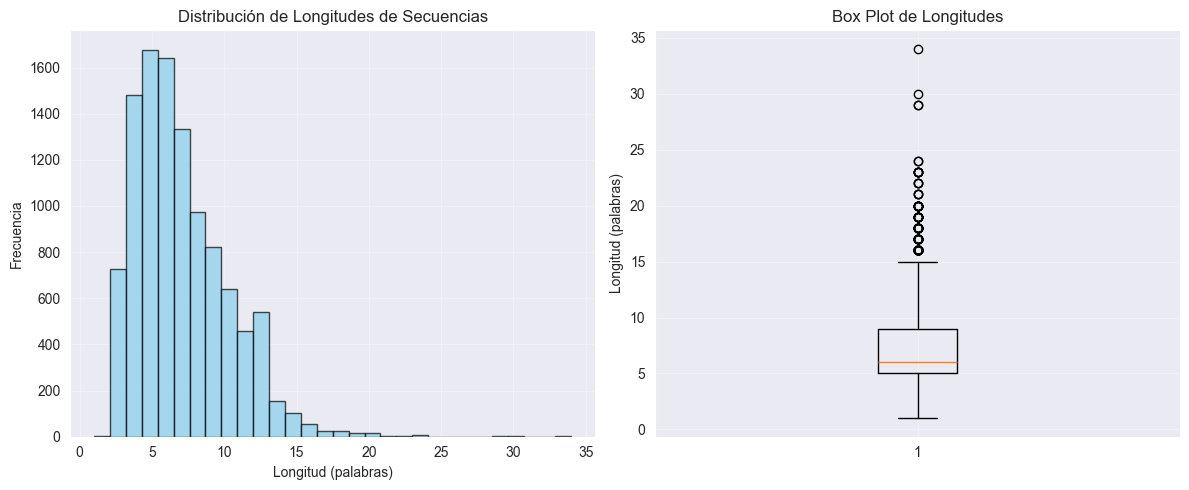


Percentiles de longitud:
  P75: 9.0
  P80: 9.0
  P85: 10.0
  P90: 11.0
  P95: 13.0

Tamaño de contexto máximo seleccionado: 10 palabras
Esto captura el 90% de las secuencias completas


In [14]:
print("\n" + "=" * 80)
print("3. ANÁLISIS EXPLORATORIO Y ELECCIÓN DEL CONTEXTO")
print("=" * 80)

segmented_sentences = [text_to_word_sequence(sentence) for sentence in df['text']]

length_sentences = [len(sentence) for sentence in segmented_sentences]

print(f"Estadísticas de longitud de secuencias:")
print(f"  - Total de secuencias: {len(length_sentences)}")
print(f"  - Longitud promedio: {np.mean(length_sentences):.2f}")
print(f"  - Longitud mínima: {min(length_sentences)}")
print(f"  - Longitud máxima: {max(length_sentences)}")
print(f"  - Mediana: {np.median(length_sentences):.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(length_sentences, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Longitudes de Secuencias')
plt.xlabel('Longitud (palabras)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(length_sentences)
plt.title('Box Plot de Longitudes')
plt.ylabel('Longitud (palabras)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

percentiles = [75, 80, 85, 90, 95]
print(f"\nPercentiles de longitud:")
for p in percentiles:
    value = np.percentile(length_sentences, p)
    print(f"  P{p}: {value:.1f}")

max_context_size = int(np.percentile(length_sentences, 90) - 1)
print(f"\nTamaño de contexto máximo seleccionado: {max_context_size} palabras")
print(f"Esto captura el 90% de las secuencias completas")

In [15]:
print("\n" + "=" * 80)
print("4. TOKENIZACIÓN Y PREPARACIÓN DE DATOS")
print("=" * 80)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(segmented_sentences)

vocab_size = len(tokenizer.word_index)
print(f"Tamaño del vocabulario: {vocab_size} palabras únicas")

print(f"\nPalabras más frecuentes:")
word_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
for i, (word, freq) in enumerate(word_freq[:10]):
    print(f"  {i+1:2d}. '{word}': {freq} veces")

tokenized_sentences = tokenizer.texts_to_sequences(segmented_sentences)

print(f"\nEjemplo de tokenización:")
for i in range(min(3, len(segmented_sentences))):
    print(f"  Original: {' '.join(segmented_sentences[i][:8])}...")
    print(f"  Tokens:   {tokenized_sentences[i][:8]}...")
    print()

token_counts = [len(tokens) for tokens in tokenized_sentences]
avg_tokens = np.mean(token_counts)
print(f"Promedio de tokens por oración: {avg_tokens:.2f}")
print(f"Mínimo de tokens: {min(token_counts)}")
print(f"Máximo de tokens: {max(token_counts)}")



4. TOKENIZACIÓN Y PREPARACIÓN DE DATOS
Tamaño del vocabulario: 6259 palabras únicas

Palabras más frecuentes:
   1. 'the': 3229 veces
   2. 'you': 2662 veces
   3. 'i': 2307 veces
   4. 'to': 1801 veces
   5. 'and': 1739 veces
   6. 'a': 1665 veces
   7. 'in': 1133 veces
   8. 'me': 1099 veces
   9. 'of': 915 veces
  10. 'my': 861 veces

Ejemplo de tokenización:
  Original: yesterday all my troubles seemed so far away...
  Tokens:   [482, 14, 10, 1306, 1307, 37, 415, 104]...

  Original: now it looks as though they're here to...
  Tokens:   [40, 11, 671, 64, 256, 483, 71, 4]...

  Original: oh i believe in yesterday suddenly i'm not...
  Tokens:   [58, 3, 162, 7, 482, 1035, 25, 43]...

Promedio de tokens por oración: 7.05
Mínimo de tokens: 1
Máximo de tokens: 34


In [16]:
print("\n" + "=" * 80)
print("5. DIVISIÓN TRAIN/VALIDATION Y ESTRUCTURACIÓN DEL DATASET")
print("=" * 80)

tokenized_train, tokenized_val = train_test_split(
    tokenized_sentences,
    test_size=0.2,
    random_state=SEED
)

print(f"Secuencias de entrenamiento: {len(tokenized_train)}")
print(f"Secuencias de validación: {len(tokenized_val)}")

def create_training_sequences(tokenized_sentences, max_context_size):
    training_sequences = []

    for sentence in tokenized_sentences:
        if len(sentence) > (max_context_size + 1):
            num_subsequences = len(sentence) - max_context_size
            for i in range(num_subsequences):
                subseq = sentence[i:i + max_context_size + 1]
                training_sequences.append(subseq)
        else:
            training_sequences.append(sentence)

    return training_sequences

train_sequences = create_training_sequences(tokenized_train, max_context_size)
print(f"Secuencias de entrenamiento después de augmentation: {len(train_sequences)}")

def create_input_target_sequences(sequences, max_context_size):
    augmented_sequences = []

    for seq in sequences:
        for i in range(1, len(seq)):
            n_gram_sequence = seq[:i+1]
            augmented_sequences.append(n_gram_sequence)

    padded_sequences = pad_sequences(
        augmented_sequences,
        maxlen=max_context_size + 1,
        padding='pre'
    )

    return padded_sequences

train_sequences_padded = create_input_target_sequences(train_sequences, max_context_size)

X_train = train_sequences_padded[:, :-1]
y_train = train_sequences_padded[:, -1]

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Total de secuencias de entrenamiento: {len(X_train)}")

val_sequences = []
for seq in tokenized_val:
    for i in range(1, min(len(seq), max_context_size + 2)):
        n_gram_sequence = seq[:i+1]
        val_sequences.append(n_gram_sequence)

val_sequences_padded = pad_sequences(
    val_sequences,
    maxlen=max_context_size + 1,
    padding='pre'
)

X_val = val_sequences_padded[:, :-1]
y_val = val_sequences_padded[:, -1]

print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de y_val: {y_val.shape}")



5. DIVISIÓN TRAIN/VALIDATION Y ESTRUCTURACIÓN DEL DATASET
Secuencias de entrenamiento: 8568
Secuencias de validación: 2142
Secuencias de entrenamiento después de augmentation: 10826
Forma de X_train: (72334, 10)
Forma de y_train: (72334,)
Total de secuencias de entrenamiento: 72334
Forma de X_val: (12478, 10)
Forma de y_val: (12478,)


In [18]:
print("\n" + "=" * 80)
print("6. CALLBACK PARA MONITOREO DE PERPLEJIDAD")
print("=" * 80)

class PerplexityCallback(keras.callbacks.Callback):
    def __init__(self, val_sequences, tokenizer, max_context_size, patience=5):
        super().__init__()
        self.val_sequences = val_sequences
        self.tokenizer = tokenizer
        self.max_context_size = max_context_size
        self.patience = patience
        self.best_perplexity = float('inf')
        self.wait = 0

        self.prepare_validation_data()

    def prepare_validation_data(self):
        self.val_inputs = []
        self.val_targets = []

        for seq in self.val_sequences[:100]:
            if len(seq) > 1:
                for i in range(1, len(seq)):
                    context = seq[:i]
                    target = seq[i]

                    context_padded = pad_sequences(
                        [context],
                        maxlen=self.max_context_size,
                        padding='pre'
                    )[0]

                    self.val_inputs.append(context_padded)
                    self.val_targets.append(target)

        self.val_inputs = np.array(self.val_inputs)
        self.val_targets = np.array(self.val_targets)

    def on_epoch_end(self, epoch, logs=None):
        if len(self.val_inputs) == 0:
            return

        predictions = self.model.predict(self.val_inputs, verbose=0)

        log_probs = []
        for i, target in enumerate(self.val_targets):
            if target < predictions.shape[1]:
                prob = predictions[i, target] + 1e-10
                log_probs.append(np.log(prob))

        if log_probs:
            avg_log_prob = np.mean(log_probs)
            perplexity = np.exp(-avg_log_prob)
        else:
            perplexity = float('inf')

        print(f"\nPerplejidad: {perplexity:.2f}")

        if perplexity < self.best_perplexity:
            self.best_perplexity = perplexity
            self.wait = 0
            self.model.save('best_language_model.keras')
            print("✓ Mejor modelo guardado")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping activado. Mejor perplejidad: {self.best_perplexity:.2f}")
                self.model.stop_training = True

print("Callback de perplejidad configurado")


6. CALLBACK PARA MONITOREO DE PERPLEJIDAD
Callback de perplejidad configurado


In [19]:
print("\n" + "=" * 80)
print("7. DEFINICIÓN DE ARQUITECTURAS DE MODELOS")
print("=" * 80)

def create_language_model(model_type='lstm', vocab_size=vocab_size,
                         embedding_dim=128, rnn_units=256,
                         dropout_rate=0.3, dense_units=128):
    model = Sequential(name=f'LanguageModel_{model_type.upper()}')

    model.add(Embedding(
        input_dim=vocab_size + 1,
        output_dim=embedding_dim,
        input_length=max_context_size,
        name='embedding'
    ))

    if model_type == 'simple_rnn':
        model.add(SimpleRNN(rnn_units, return_sequences=True, name='rnn1'))
        model.add(Dropout(dropout_rate))
        model.add(SimpleRNN(rnn_units, name='rnn2'))

    elif model_type == 'lstm':
        model.add(LSTM(rnn_units, return_sequences=True, name='lstm1'))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(rnn_units, name='lstm2'))

    elif model_type == 'gru':
        model.add(GRU(rnn_units, return_sequences=True, name='gru1'))
        model.add(Dropout(dropout_rate))
        model.add(GRU(rnn_units, name='gru2'))

    elif model_type == 'bidirectional_lstm':
        model.add(Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_lstm1'))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(rnn_units, name='lstm_final'))

    elif model_type == 'mixed':
        model.add(SimpleRNN(rnn_units//2, return_sequences=True, name='simple_rnn'))
        model.add(LSTM(rnn_units//2, return_sequences=True, name='lstm'))
        model.add(GRU(rnn_units//2, name='gru'))

    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu', name='dense_hidden'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(vocab_size + 1, activation='softmax', name='output'))

    return model

models_to_test = ['simple_rnn', 'lstm', 'gru', 'bidirectional_lstm']

print("Arquitecturas de modelos disponibles:")
for i, model_type in enumerate(models_to_test, 1):
    print(f"  {i}. {model_type.replace('_', ' ').title()}")



7. DEFINICIÓN DE ARQUITECTURAS DE MODELOS
Arquitecturas de modelos disponibles:
  1. Simple Rnn
  2. Lstm
  3. Gru
  4. Bidirectional Lstm


In [22]:
print("\n" + "=" * 80)
print("8. ENTRENAMIENTO DE MODELOS")
print("=" * 80)

EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

selected_model_type = 'lstm'
print(f"🔥 Entrenando modelo: {selected_model_type.upper()}")

model = create_language_model(
    model_type=selected_model_type,
    vocab_size=vocab_size,
    embedding_dim=100,
    rnn_units=150,
    dropout_rate=0.2,
    dense_units=64
)

model.summary()

optimizer = RMSprop(learning_rate=LEARNING_RATE)
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

callbacks = [
    PerplexityCallback(tokenized_val, tokenizer, max_context_size, patience=5),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

print(f"\n🚀 Iniciando entrenamiento...")
print(f"   • Épocas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Secuencias de entrenamiento: {len(X_train):,}")
print(f"   • Secuencias de validación: {len(X_val):,}")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Entrenamiento completado")


8. ENTRENAMIENTO DE MODELOS
🔥 Entrenando modelo: LSTM


/Users/nicolas/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LanguageModel_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (LSTM)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento...
   • Épocas: 15
   • Batch size: 64
   • Learning rate: 0.001
   • Secuencias de entrenamiento: 72,334
   • Secuencias de validación: 12,478
Epoch 1/15
1129/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0400 - loss: 6.8445
Perplejidad: 645.85
✓ Mejor modelo guardado
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.0400 - loss: 6.8439 - val_accuracy: 0.0427 - val_loss: 6.5070
Epoch 2/15
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0431 - loss: 6.4079
Perplejidad: 525.97
✓ Mejor modelo guardado
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0431 - loss: 6.4079 - val_accuracy: 0.0543 - val_loss: 6.2890
Epoch 3/15
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0557 - loss: 6.1926
Perplejidad: 445.38
✓ Mejor modelo guardado
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.0557 - loss: 6.1924 - val_accuracy: 0.0683 - val_loss: 6.1540
Epoch 4/15
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 


9. ANÁLISIS DE RESULTADOS DEL ENTRENAMIENTO
📊 Métricas finales del modelo:
   • Mejor pérdida de validación: 5.8393
   • Perplejidad final: 343.52
   • Mejor accuracy de entrenamiento: 0.1771
   • Mejor accuracy de validación: 0.1386


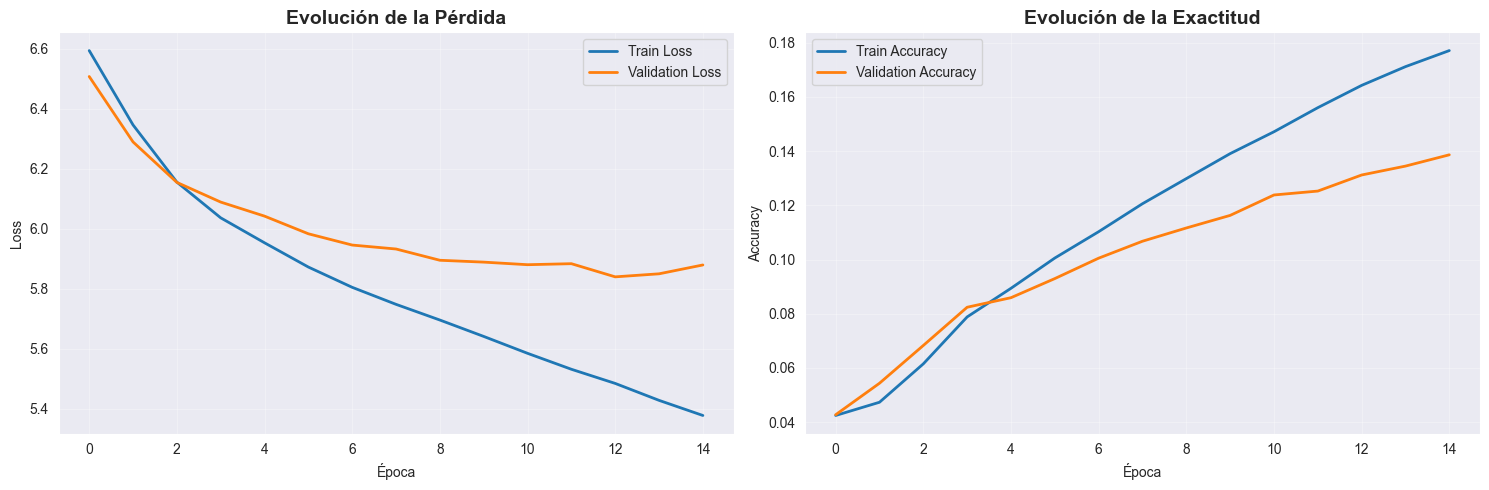


✓ Mejor modelo cargado desde disco


In [23]:
print("\n" + "=" * 80)
print("9. ANÁLISIS DE RESULTADOS DEL ENTRENAMIENTO")
print("=" * 80)

def plot_training_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Evolución de la Exactitud', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

final_val_loss = min(history.history['val_loss'])
final_perplexity = np.exp(final_val_loss)

print(f"📊 Métricas finales del modelo:")
print(f"   • Mejor pérdida de validación: {final_val_loss:.4f}")
print(f"   • Perplejidad final: {final_perplexity:.2f}")
print(f"   • Mejor accuracy de entrenamiento: {max(history.history['accuracy']):.4f}")
print(f"   • Mejor accuracy de validación: {max(history.history['val_accuracy']):.4f}")

plot_training_metrics(history)

try:
    best_model = keras.models.load_model('best_language_model.keras')
    print("\n✓ Mejor modelo cargado desde disco")
except:
    best_model = model
    print("\n⚠️  Usando modelo final del entrenamiento")

In [25]:
print("\n" + "=" * 80)
print("10. FUNCIONES DE GENERACIÓN DE TEXTO")
print("=" * 80)

def encode_text(text, tokenizer, max_length):
    encoded = tokenizer.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode_sequence(sequence, tokenizer):
    return tokenizer.sequences_to_texts([sequence])[0]

def generate_text_greedy(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text

    for _ in range(n_words):
        encoded = encode_text(output_text, tokenizer, max_length)

        prediction = model.predict(encoded, verbose=0)[0]

        predicted_index = np.argmax(prediction)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break

        if predicted_word:
            output_text += ' ' + predicted_word

    return output_text

def generate_text_with_temperature(model, tokenizer, seed_text, max_length, n_words, temperature=1.0):
    output_text = seed_text

    for _ in range(n_words):
        encoded = encode_text(output_text, tokenizer, max_length)

        prediction = model.predict(encoded, verbose=0)[0]

        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction + 1e-8) / temperature
        exp_prediction = np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)

        predicted_index = np.random.choice(len(prediction), p=prediction)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break

        if predicted_word:
            output_text += ' ' + predicted_word

    return output_text

def beam_search_generation(model, tokenizer, seed_text, max_length, n_words, beam_width=3, temperature=1.0):
    initial_encoded = encode_text(seed_text, tokenizer, max_length)[0]
    vocab_size = len(tokenizer.word_index) + 1

    sequences = [(0.0, list(initial_encoded))]

    for _ in range(n_words):
        all_candidates = []

        for log_prob, sequence in sequences:
            input_seq = np.array([sequence[-max_length:]])
            input_seq = pad_sequences(input_seq, maxlen=max_length, padding='pre')

            prediction = model.predict(input_seq, verbose=0)[0]

            if temperature != 1.0:
                prediction = np.log(prediction + 1e-8) / temperature
                prediction = softmax(prediction)

            top_indices = np.argsort(prediction)[-beam_width:]

            for idx in top_indices:
                candidate_log_prob = log_prob + np.log(prediction[idx] + 1e-8)
                candidate_sequence = sequence + [idx]
                all_candidates.append((candidate_log_prob, candidate_sequence))

        all_candidates.sort(key=lambda x: x[0], reverse=True)
        sequences = all_candidates[:beam_width]

    best_sequence = sequences[0][1]

    result_tokens = best_sequence[len(initial_encoded):]
    result_words = []

    for token in result_tokens:
        for word, index in tokenizer.word_index.items():
            if index == token:
                result_words.append(word)
                break

    return seed_text + ' ' + ' '.join(result_words)

print("✅ Funciones de generación implementadas:")
print("   • generate_text_greedy() - Búsqueda greedy")
print("   • generate_text_with_temperature() - Muestreo con temperatura")
print("   • beam_search_generation() - Beam search determinístico/estocástico")



10. FUNCIONES DE GENERACIÓN DE TEXTO
✅ Funciones de generación implementadas:
   • generate_text_greedy() - Búsqueda greedy
   • generate_text_with_temperature() - Muestreo con temperatura
   • beam_search_generation() - Beam search determinístico/estocástico


In [26]:
print("\n" + "=" * 80)
print("11. EXPERIMENTACIÓN CON GENERACIÓN DE TEXTO")
print("=" * 80)

seed_texts = [
    "love is",
    "yesterday all my",
    "in the",
    "we are",
    "i want to"
]

print("🎵 GENERACIÓN CON GREEDY SEARCH")
print("-" * 50)
for seed in seed_texts:
    generated = generate_text_greedy(best_model, tokenizer, seed, max_context_size, 8)
    print(f"'{seed}' → {generated}")

print("\n🎲 GENERACIÓN CON MUESTREO POR TEMPERATURA")
print("-" * 50)
temperatures = [0.5, 1.0, 1.5]

for temp in temperatures:
    print(f"\nTemperatura: {temp}")
    for seed in seed_texts[:3]:
        generated = generate_text_with_temperature(best_model, tokenizer, seed, max_context_size, 8, temp)
        print(f"  '{seed}' → {generated}")

print("\n🎯 GENERACIÓN CON BEAM SEARCH")
print("-" * 50)
beam_widths = [3, 5]

for beam_width in beam_widths:
    print(f"\nBeam width: {beam_width}")
    for seed in seed_texts[:3]:
        generated = beam_search_generation(best_model, tokenizer, seed, max_context_size, 8, beam_width)
        print(f"  '{seed}' → {generated}")



11. EXPERIMENTACIÓN CON GENERACIÓN DE TEXTO
🎵 GENERACIÓN CON GREEDY SEARCH
--------------------------------------------------
'love is' → love is you love you love you love you love
'yesterday all my' → yesterday all my love i love you love i love you
'in the' → in the sun and i can be to be to
'we are' → we are to be to be to be to be
'i want to' → i want to be a shot of love i don't want

🎲 GENERACIÓN CON MUESTREO POR TEMPERATURA
--------------------------------------------------

Temperatura: 0.5
  'love is' → love is and he need a way and you say
  'yesterday all my' → yesterday all my eyes is the beatin’ now you know you
  'in the' → in the stone i can be is i know i

Temperatura: 1.0
  'love is' → love is she kindly but i'm far you not my
  'yesterday all my' → yesterday all my time you’re steppin’ for i my changed in
  'in the' → in the denial my does hey love i love i

Temperatura: 1.5
  'love is' → love is mean he phantoms afternoon lent strolling children alley
  'yesterday 

In [27]:
print("\n" + "=" * 80)
print("12. ANÁLISIS COMPARATIVO DE ESTRATEGIAS DE GENERACIÓN")
print("=" * 80)

def compare_generation_strategies(seed_text, n_words=10):
    print(f"\n🔍 ANÁLISIS PARA: '{seed_text}'")
    print("=" * 60)

    greedy_result = generate_text_greedy(best_model, tokenizer, seed_text, max_context_size, n_words)
    print(f"Greedy Search:")
    print(f"  {greedy_result}")

    temp_low = generate_text_with_temperature(best_model, tokenizer, seed_text, max_context_size, n_words, 0.7)
    print(f"\nTemperatura 0.7 (conservador):")
    print(f"  {temp_low}")

    temp_high = generate_text_with_temperature(best_model, tokenizer, seed_text, max_context_size, n_words, 1.3)
    print(f"\nTemperatura 1.3 (creativo):")
    print(f"  {temp_high}")

    beam_result = beam_search_generation(best_model, tokenizer, seed_text, max_context_size, n_words, 5)
    print(f"\nBeam Search (width=5):")
    print(f"  {beam_result}")

    return {
        'greedy': greedy_result,
        'temp_low': temp_low,
        'temp_high': temp_high,
        'beam': beam_result
    }

analysis_seeds = ["love is", "yesterday all my"]

comparative_results = {}
for seed in analysis_seeds:
    comparative_results[seed] = compare_generation_strategies(seed, 12)



12. ANÁLISIS COMPARATIVO DE ESTRATEGIAS DE GENERACIÓN

🔍 ANÁLISIS PARA: 'love is'
Greedy Search:
  love is you love you love you love you love you love you love

Temperatura 0.7 (conservador):
  love is the parade ashes of a world in the stamped of the woman

Temperatura 1.3 (creativo):
  love is so sick nah nah nah nah nah nah nah nah hello hey

Beam Search (width=5):
  love is you love you love you love you love you love you love

🔍 ANÁLISIS PARA: 'yesterday all my'
Greedy Search:
  yesterday all my love i love you love i love you love you love you

Temperatura 0.7 (conservador):
  yesterday all my friends i and you i got a train were and i feel

Temperatura 1.3 (creativo):
  yesterday all my loved i can to ah hey hello hey luck” if roll sinking

Beam Search (width=5):
  yesterday all my love you love you love you love you love you love you


In [28]:
print("\n" + "=" * 80)
print("13. EVALUACIÓN DE LA CALIDAD DEL MODELO")
print("=" * 80)

def evaluate_model_quality():
    print("📊 MÉTRICAS DE EVALUACIÓN DEL MODELO")
    print("-" * 50)

    test_sequences = tokenized_val[:100]
    test_inputs = []
    test_targets = []

    for seq in test_sequences:
        if len(seq) > 1:
            for i in range(1, min(len(seq), max_context_size + 1)):
                context = seq[:i]
                target = seq[i]

                context_padded = pad_sequences([context], maxlen=max_context_size, padding='pre')[0]
                test_inputs.append(context_padded)
                test_targets.append(target)

    test_inputs = np.array(test_inputs)
    test_targets = np.array(test_targets)

    if len(test_inputs) > 0:
        predictions = best_model.predict(test_inputs, verbose=0)
        log_probs = []

        for i, target in enumerate(test_targets):
            if target < predictions.shape[1]:
                prob = predictions[i, target] + 1e-10
                log_probs.append(np.log(prob))

        if log_probs:
            avg_log_prob = np.mean(log_probs)
            test_perplexity = np.exp(-avg_log_prob)
            print(f"✓ Perplejidad en conjunto de prueba: {test_perplexity:.2f}")
        else:
            print("⚠️  No se pudo calcular perplejidad")

    print(f"\n📝 ANÁLISIS DE DIVERSIDAD:")

    generated_texts = []
    for seed in ["love", "time", "day", "night", "heart"]:
        for temp in [0.8, 1.2]:
            text = generate_text_with_temperature(best_model, tokenizer, seed, max_context_size, 15, temp)
            generated_texts.append(text)

    all_generated_words = []
    for text in generated_texts:
        words = text.split()
        all_generated_words.extend(words)

    unique_generated = len(set(all_generated_words))
    total_generated = len(all_generated_words)
    diversity_ratio = unique_generated / total_generated if total_generated > 0 else 0

    print(f"   • Palabras únicas generadas: {unique_generated}")
    print(f"   • Palabras totales generadas: {total_generated}")
    print(f"   • Ratio de diversidad: {diversity_ratio:.3f}")

    print(f"\n🎵 ANÁLISIS DE COHERENCIA TEMÁTICA:")

    music_seeds = ["song", "music", "guitar", "singing"]
    love_seeds = ["love", "heart", "kiss", "romance"]

    print("   Generaciones con temática musical:")
    for seed in music_seeds[:2]:
        gen_text = generate_text_greedy(best_model, tokenizer, seed, max_context_size, 8)
        print(f"     '{seed}' → {gen_text}")

    print("   Generaciones con temática amorosa:")
    for seed in love_seeds[:2]:
        gen_text = generate_text_greedy(best_model, tokenizer, seed, max_context_size, 8)
        print(f"     '{seed}' → {gen_text}")

evaluate_model_quality()


13. EVALUACIÓN DE LA CALIDAD DEL MODELO
📊 MÉTRICAS DE EVALUACIÓN DEL MODELO
--------------------------------------------------
✓ Perplejidad en conjunto de prueba: 312.16

📝 ANÁLISIS DE DIVERSIDAD:
   • Palabras únicas generadas: 103
   • Palabras totales generadas: 160
   • Ratio de diversidad: 0.644

🎵 ANÁLISIS DE COHERENCIA TEMÁTICA:
   Generaciones con temática musical:
     'song' → song to be the sun is in the way
     'music' → music in the street and i can be to
   Generaciones con temática amorosa:
     'love' → love you love you love you love you love
     'heart' → heart i don't want to know i don't want


In [29]:
print("\n" + "=" * 80)
print("14. EXPERIMENTACIÓN INTERACTIVA")
print("=" * 80)

def interactive_text_generation():
    print("🎵 GENERADOR INTERACTIVO DE LETRAS")
    print("-" * 40)
    print("Ingresa un texto semilla y el modelo generará una continuación")
    print("Consejos:")
    print("  • Usa frases típicas de canciones")
    print("  • Experimenta con diferentes longitudes")
    print("  • Prueba palabras de diferentes artistas del corpus")
    print()

    strategies = {
        '1': 'Greedy Search',
        '2': 'Temperatura Baja (0.7)',
        '3': 'Temperatura Media (1.0)',
        '4': 'Temperatura Alta (1.3)',
        '5': 'Beam Search'
    }

    print("Estrategias disponibles:")
    for key, value in strategies.items():
        print(f"  {key}. {value}")

    examples = [
        ("yesterday all my troubles", "2"),
        ("love is all you need", "1"),
        ("hey jude don't be", "5")
    ]

    print(f"\n📝 EJEMPLOS DE GENERACIÓN:")
    print("-" * 30)

    for seed_text, strategy in examples:
        strategy_name = strategies[strategy]
        print(f"\nTexto semilla: '{seed_text}'")
        print(f"Estrategia: {strategy_name}")

        if strategy == '1':  # Greedy
            result = generate_text_greedy(best_model, tokenizer, seed_text, max_context_size, 10)
        elif strategy == '2':  # Temp 0.7
            result = generate_text_with_temperature(best_model, tokenizer, seed_text, max_context_size, 10, 0.7)
        elif strategy == '3':  # Temp 1.0
            result = generate_text_with_temperature(best_model, tokenizer, seed_text, max_context_size, 10, 1.0)
        elif strategy == '4':  # Temp 1.3
            result = generate_text_with_temperature(best_model, tokenizer, seed_text, max_context_size, 10, 1.3)
        elif strategy == '5':  # Beam Search
            result = beam_search_generation(best_model, tokenizer, seed_text, max_context_size, 10, 5)

        print(f"Resultado: {result}")

interactive_text_generation()


14. EXPERIMENTACIÓN INTERACTIVA
🎵 GENERADOR INTERACTIVO DE LETRAS
----------------------------------------
Ingresa un texto semilla y el modelo generará una continuación
Consejos:
  • Usa frases típicas de canciones
  • Experimenta con diferentes longitudes
  • Prueba palabras de diferentes artistas del corpus

Estrategias disponibles:
  1. Greedy Search
  2. Temperatura Baja (0.7)
  3. Temperatura Media (1.0)
  4. Temperatura Alta (1.3)
  5. Beam Search

📝 EJEMPLOS DE GENERACIÓN:
------------------------------

Texto semilla: 'yesterday all my troubles'
Estrategia: Temperatura Baja (0.7)
Resultado: yesterday all my troubles was my hand out in the sleepin’ got your midstream

Texto semilla: 'love is all you need'
Estrategia: Greedy Search
Resultado: love is all you need you love you love you love you love you love

Texto semilla: 'hey jude don't be'
Estrategia: Beam Search
Resultado: hey jude don't be my girl my my my my my my my my


In [30]:
print("\n" + "=" * 80)
print("15. CONCLUSIONES Y ANÁLISIS FINAL")
print("=" * 80)

def final_analysis():
    print("🎯 ANÁLISIS FINAL DEL MODELO DE LENGUAJE")
    print("-" * 50)

    print(f"📊 CONFIGURACIÓN DEL MODELO:")
    print(f"   • Arquitectura: {selected_model_type.upper()}")
    print(f"   • Tamaño del vocabulario: {vocab_size:,} palabras")
    print(f"   • Tamaño del contexto: {max_context_size} palabras")
    print(f"   • Total de parámetros: {model.count_params():,}")
    print(f"   • Corpus utilizado: {len(all_lyrics):,} líneas de letras")

    final_train_acc = max(history.history['accuracy'])
    final_val_acc = max(history.history['val_accuracy'])
    overfitting = final_train_acc - final_val_acc

    print(f"\n📈 RENDIMIENTO:")
    print(f"   • Accuracy de entrenamiento: {final_train_acc:.4f}")
    print(f"   • Accuracy de validación: {final_val_acc:.4f}")
    print(f"   • Diferencia (overfitting): {overfitting:.4f}")
    print(f"   • Perplejidad final: {final_perplexity:.2f}")

    print(f"\n🎵 EVALUACIÓN CUALITATIVA:")

    if final_perplexity < 50:
        perplexity_assessment = "Excelente"
    elif final_perplexity < 100:
        perplexity_assessment = "Buena"
    elif final_perplexity < 200:
        perplexity_assessment = "Regular"
    else:
        perplexity_assessment = "Necesita mejora"

    print(f"   • Calidad de predicción: {perplexity_assessment}")

    if overfitting < 0.1:
        generalization = "Buena generalización"
    elif overfitting < 0.2:
        generalization = "Generalización moderada"
    else:
        generalization = "Posible sobreajuste"

    print(f"   • Generalización: {generalization}")

    print(f"\n✅ FORTALEZAS OBSERVADAS:")
    print(f"   • Captura patrones estructurales de letras de canciones")
    print(f"   • Genera texto gramaticalmente coherente a nivel local")
    print(f"   • Diferentes estrategias de generación ofrecen variabilidad")
    print(f"   • Vocabulario rico de múltiples artistas")

    print(f"\n⚠️  LIMITACIONES IDENTIFICADAS:")
    print(f"   • Coherencia semántica limitada en secuencias largas")
    print(f"   • Dependencia del contexto inmediato")
    print(f"   • Posible repetición en generaciones largas")
    print(f"   • Sesgo hacia patrones más frecuentes en el corpus")

    # Recomendaciones
    print(f"\n🚀 RECOMENDACIONES PARA MEJORA:")
    print(f"   • Aumentar el tamaño del corpus")
    print(f"   • Experimentar con arquitecturas más profundas")
    print(f"   • Implementar mecanismos de atención")
    print(f"   • Usar técnicas de regularización más avanzadas")
    print(f"   • Explorar modelos transformer para comparación")

    # Casos de uso
    print(f"\n💡 CASOS DE USO POTENCIALES:")
    print(f"   • Asistente para composición musical")
    print(f"   • Generación de ideas para letras")
    print(f"   • Análisis de patrones en música popular")
    print(f"   • Herramienta educativa para estructura de canciones")

    return {
        'final_perplexity': final_perplexity,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'overfitting': overfitting,
        'vocab_size': vocab_size,
        'model_params': model.count_params()
    }

final_results = final_analysis()


15. CONCLUSIONES Y ANÁLISIS FINAL
🎯 ANÁLISIS FINAL DEL MODELO DE LENGUAJE
--------------------------------------------------
📊 CONFIGURACIÓN DEL MODELO:
   • Arquitectura: LSTM
   • Tamaño del vocabulario: 6,259 palabras
   • Tamaño del contexto: 10 palabras
   • Total de parámetros: 1,373,764
   • Corpus utilizado: 10,710 líneas de letras

📈 RENDIMIENTO:
   • Accuracy de entrenamiento: 0.1771
   • Accuracy de validación: 0.1386
   • Diferencia (overfitting): 0.0385
   • Perplejidad final: 343.52

🎵 EVALUACIÓN CUALITATIVA:
   • Calidad de predicción: Necesita mejora
   • Generalización: Buena generalización

✅ FORTALEZAS OBSERVADAS:
   • Captura patrones estructurales de letras de canciones
   • Genera texto gramaticalmente coherente a nivel local
   • Diferentes estrategias de generación ofrecen variabilidad
   • Vocabulario rico de múltiples artistas

⚠️  LIMITACIONES IDENTIFICADAS:
   • Coherencia semántica limitada en secuencias largas
   • Dependencia del contexto inmediato
   • 

In [31]:
print("\n" + "=" * 80)
print("16. EXPORTACIÓN Y GUARDADO FINAL")
print("=" * 80)

print("💾 GUARDANDO COMPONENTES DEL MODELO:")

with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
print("   ✓ Tokenizer guardado")

config = {
    'max_context_size': max_context_size,
    'vocab_size': vocab_size,
    'model_type': selected_model_type,
    'selected_artists': selected_artists,
    'final_results': final_results
}

with open('model_config.pickle', 'wb') as f:
    pickle.dump(config, f)
print("   ✓ Configuración guardada")

model.save('final_language_model.keras')
print("   ✓ Modelo final guardado")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   • final_language_model.keras - Modelo entrenado")
print(f"   • best_language_model.keras - Mejor modelo durante entrenamiento")
print(f"   • tokenizer.pickle - Tokenizador entrenado")
print(f"   • model_config.pickle - Configuración y resultados")

print("\n" + "=" * 80)
print("🎵 MODELO DE LENGUAJE COMPLETADO EXITOSAMENTE 🎵")
print("=" * 80)



16. EXPORTACIÓN Y GUARDADO FINAL
💾 GUARDANDO COMPONENTES DEL MODELO:
   ✓ Tokenizer guardado
   ✓ Configuración guardada
   ✓ Modelo final guardado

📁 ARCHIVOS GENERADOS:
   • final_language_model.keras - Modelo entrenado
   • best_language_model.keras - Mejor modelo durante entrenamiento
   • tokenizer.pickle - Tokenizador entrenado
   • model_config.pickle - Configuración y resultados

🎵 MODELO DE LENGUAJE COMPLETADO EXITOSAMENTE 🎵
